## Exploratory Data Analysis

### Exploring Household full text

In [3]:
print('# Unique Values of Houshold full text:',len(food_train.household_serving_fulltext.unique()))

# Unique Values of Houshold full text: 2207


#### Cleaning the Column

In [6]:
food_train = clean_column(food_train,'household_serving_fulltext')

In [7]:
food_train.household_serving_fulltext.value_counts()[0:10]

1 onz        5424
025 cup      2160
3 pieces     1238
1 cookies    1160
2 cookies     914
4 pieces      838
1 pack        811
1 pieces      803
2 pieces      607
5 pieces      572
Name: household_serving_fulltext, dtype: int64

We will compare between different values of pieces and cookies to see if the number of units affects the distribution of labels.


#### Are the digits important?

When we look at houshold values we see different values of numbers with the same text - 2 pieces, 3 pieces etc...<br>
We will check if there is any importance to the digits in household_serving_fulltext (is label distribution different).<br>
Let's take a look only at values that contains a digit.

In [5]:
food_train.household_serving_fulltext[food_train.household_serving_fulltext.str.contains('\d+', na=False)].value_counts()[0:20]

1 onz        5424
0.25 cup     2116
3 pieces     1114
1 cookie     1074
2 cookies     889
4 pieces      744
1 piece       680
1 package     585
2 pieces      538
5 pieces      467
1 bar         441
3 cookies     403
1/4 cup       398
1 pouch       320
1 slice       316
1.5 onz       297
2 tbsp        294
6 pieces      290
1.4 onz       275
0.5 bar       254
Name: household_serving_fulltext, dtype: int64

We plot the categories for each quantity of household serving for "pieces". 

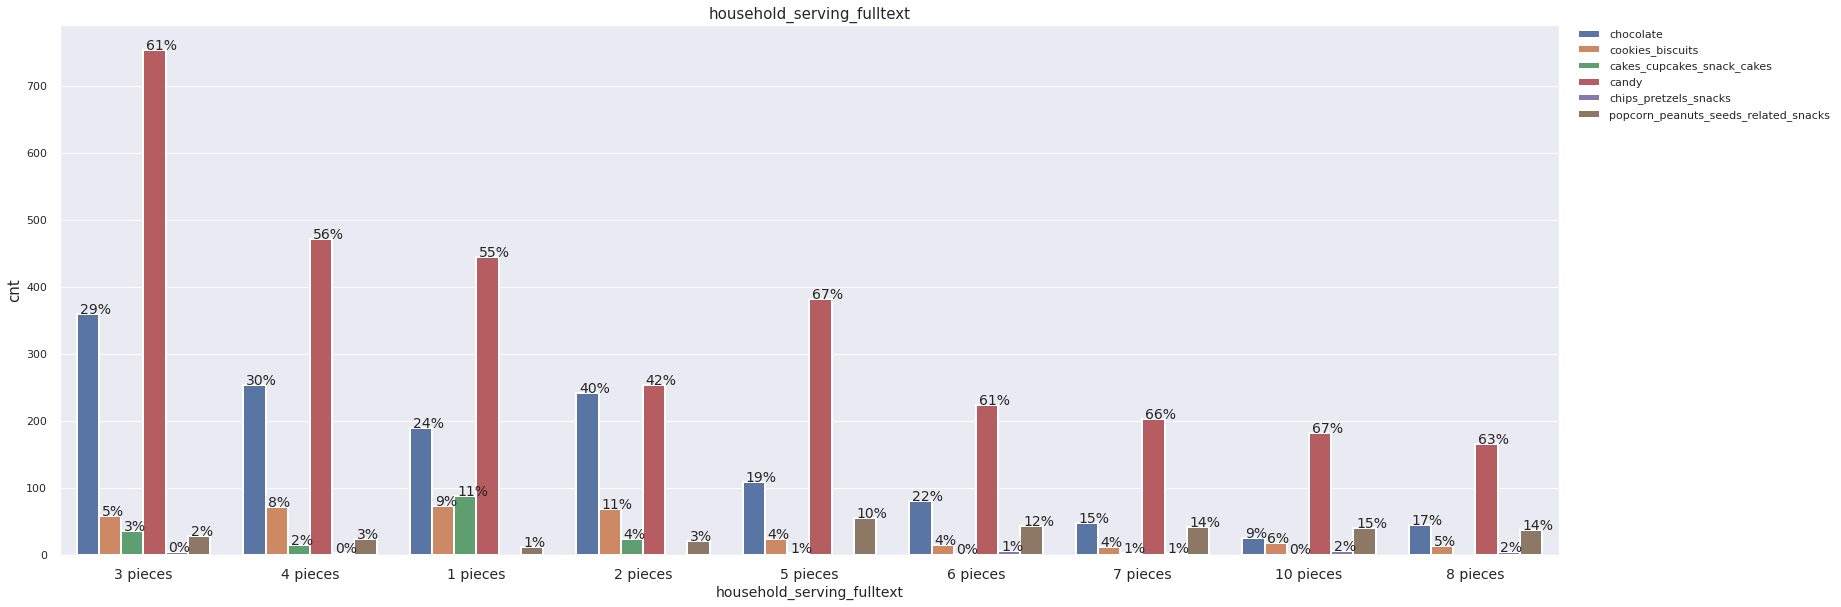

In [16]:
cnt_piece = food_train.household_serving_fulltext[food_train.household_serving_fulltext.str.contains('piece')].value_counts()
sns.set(rc={'figure.figsize':(25.7,8.27)})

ax = sns.countplot(x='household_serving_fulltext', data=food_train,
                  # facecolor=(0, 0, 0, 0),
                   linewidth=2,
                   hue = food_train.category,
                   order=cnt_piece.index[0:9]
                   #,legend=False
                  )
#ax.despine(left=True)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.tight_layout()
plt.title("household_serving_fulltext",fontsize=15)
ax.set_xlabel('household_serving_fulltext',fontsize=14)
ax.set_ylabel('cnt',fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)


with_hue(ax, food_train.household_serving_fulltext[food_train.household_serving_fulltext.str.contains('piece')], 9, 6)   

we see that "pieces" label distribution does not change much with quantity, and that the number in " # pieces" does not contain information about the label (it is quite likely to be a candy).<br> So we will assume can ignore the number, and use the word "pieces" as a feature. 

The same affect is observed in "cookies" (see Apendix)<br> the unit of measurement is almost entirely correlated with one label but the quantity does not mean a lot.<br> So we can ignore the number and leave the unit as a feature.

Hence we remove the digits from household_serving_fulltext since the category distribution looks similiar both in cookies and in pieces.

In [18]:
# Clean from digits
food_train['household_serving_fulltext'] = food_train.household_serving_fulltext.str.replace('\d+', '')

We can see that each houshold value have different distribution from another which means it might be a good feature :) (Appendix)

In [21]:
print('# Unique values of household_serving_fulltext: ',len(food_train.household_serving_fulltext.unique()))

# Unique values of household_serving_fulltext:  572


### Augmented feature

We can hypothesize that units that measure quantity/volume/weight contain distinctive information about the label, different than units that count items.<br> Let's see if it make sense.

In [39]:
food_train = add_is_houshold_unit(food_train) # helper function

<AxesSubplot:title={'center':'Category per Is Houshold Unit'}>

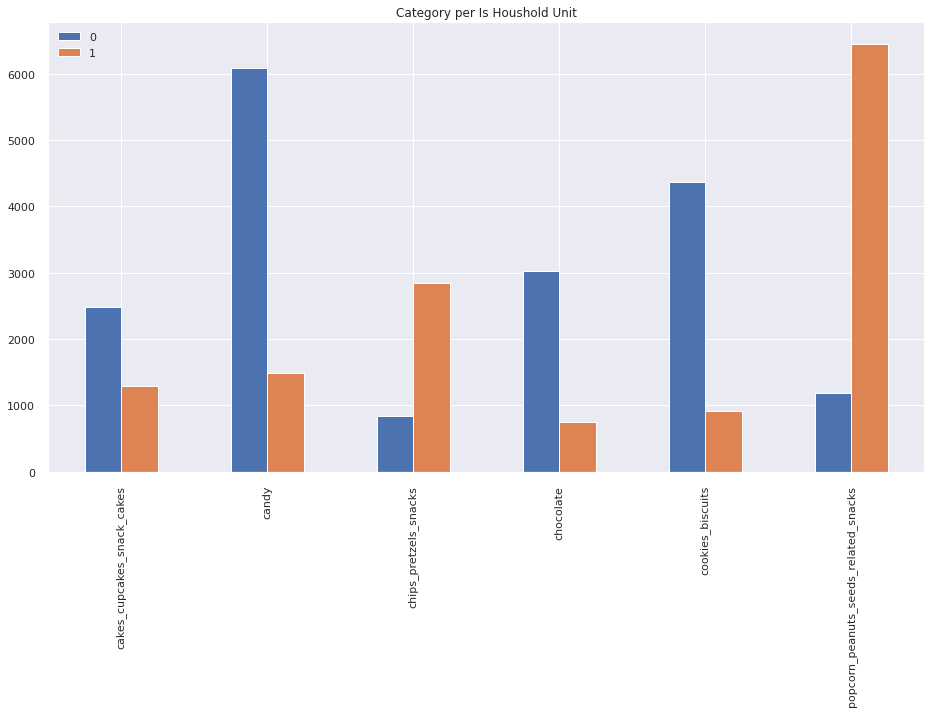

In [43]:
df_houshold_unit.plot(kind = 'bar',title = 'Category per Is Houshold Unit') # df_houshold_unit in Appendix

We see that this feature has some information about the label (e.g. popcorn_etc category is dominated by units that are quantity based)<br>
So we will try to add it as a feature.

#### Basic cleaning

In [55]:
food_train['description'] = food_train.description.map(lambda a: preprocess(a))

Let's check if there is a difference in the #words between the different categories.

In [10]:
food_train['# description words'] = food_train.description.str.count(' ') + 1
food_train[['description','# description words']].sort_values(by='# description words', ascending=True)
food_train.groupby('category')['# description words'].mean()

category
cakes_cupcakes_snack_cakes              4.062071
candy                                   4.436973
chips_pretzels_snacks                   4.953261
chocolate                               5.128314
cookies_biscuits                        4.546177
popcorn_peanuts_seeds_related_snacks    4.524264
Name: # description words, dtype: float64

We see that there is a small difference between the different categories - maybe it can be a feature.<br>
We will check it on the data for this decision.

#### Word Frequency

After stemmimg and removing 'stop words' we would like to see the affect frequency of top n words on the category distribution.<br>
Let's take a look on the cleaned descriptions.

In [76]:
full_description_word_list = get_full_description_word_list(food_train)
print('# Words in descriptions: ',len(full_description_word_list))
print('# Unique Words in descriptions: ',len(set(full_description_word_list)))

# Words in descriptions:  137943
# Unique Words in descriptions:  5898


By quick look we see that 'cooki' (stemmed cookies or cookie) repeats a lot.<br>
What will be the most repeated word and will it show label separation?<br>
We will take the most repeated 10 words by each category so we won't be affected by class imbalance.

The top 10 words by each category leaves us with only 43 key words. Let's examine their frequency per caterogy to see if they contain distinctive information (not spread out evenly across categories) (code in the appendix)

In [62]:
len(description_keywords)

43

<AxesSubplot:title={'center':'Stacked Bar Graph'}>

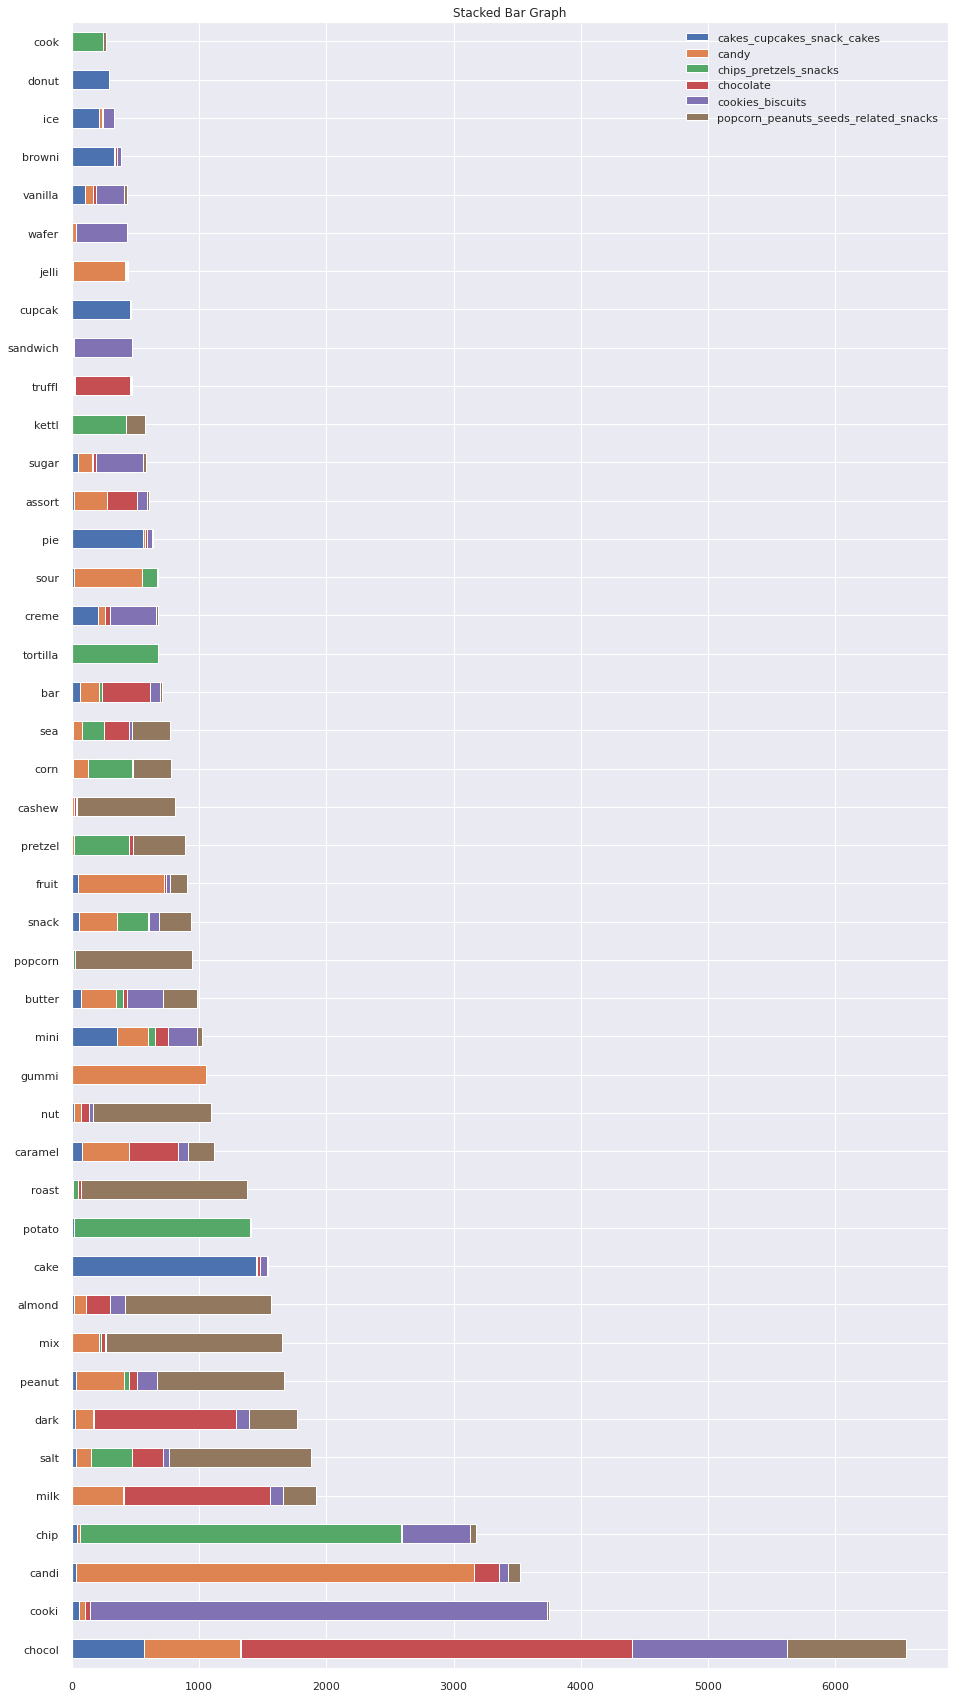

In [65]:
sns.set(rc={'figure.figsize':(15.7,30.27)})
df_t.plot(
    x = df_t.index.name,
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True)


So the most frequent word is 'chocol' (stemmed 'chocolate' or 'chocolaty' etc...):<br>
Most of it's apperences belongs to the chocolate category and the least of it's appearences belongs to cakes category.<br>
The are many words that almost completly colored by one category as 'cooki', 'candi','cake','potato' etc.<br>
This shows very well the impact of appearence each word in the description, which can be a binary feature.

### Ingredients

We apply some basic cleaning to the list of ingredients.

In [6]:
food_train.ingredients = food_train.ingredients.map(lambda a: clean_ingredients(a))

In [11]:
full_ingredients = get_full_ingredients_list(food_train)
print('#Ingredients in all snacks: ',len(full_ingredients))
print('# Unique Ingredients in all snacks: ',len(set(full_ingredients)))

#Ingredients in all snacks:  333592
# Unique Ingredients in all snacks:  31186


Let's take a look at # ingredients per category.

In [3]:
food_train['# ingredients'] = food_train.ingredients.str.count(',') + 1

In [7]:
food_train.groupby('category')['# ingredients'].mean()

category
cakes_cupcakes_snack_cakes              40.894472
candy                                   12.801055
chips_pretzels_snacks                   12.588747
chocolate                               15.167374
cookies_biscuits                        22.158682
popcorn_peanuts_seeds_related_snacks    10.799213
Name: # ingredients, dtype: float64

We see a clear difference between the different categories and cakes and cupcake appearently have the most ingredients in it.<br>

Let's take a look on the first ingredient only (which is contained the most).

In [8]:
food_train[['first_ingredient','second+_ingredients']] = food_train.ingredients.str.split(',',n=1,expand=True)

In [9]:
print('unique first ingredient values in the dataset: ',len(set(food_train.first_ingredient)))

unique first ingredient values in the dataset:  2885


#### First Ingredient Frequency By Category - In the Appendix

#### Different Shades Of Flour 

Let's examine the 'flour' variations of the first ingredient.

In [11]:
print('Unique first ingredient contain \'flour\' values in the dataset: ',len(set(food_train.first_ingredient[food_train.first_ingredient.str.contains("flour")])))


Unique first ingredient contain 'flour' values in the dataset:  295


There are many kinds of flour in our data set, let's see what is the category distribution of the top values of first ingredient with 'flour'.

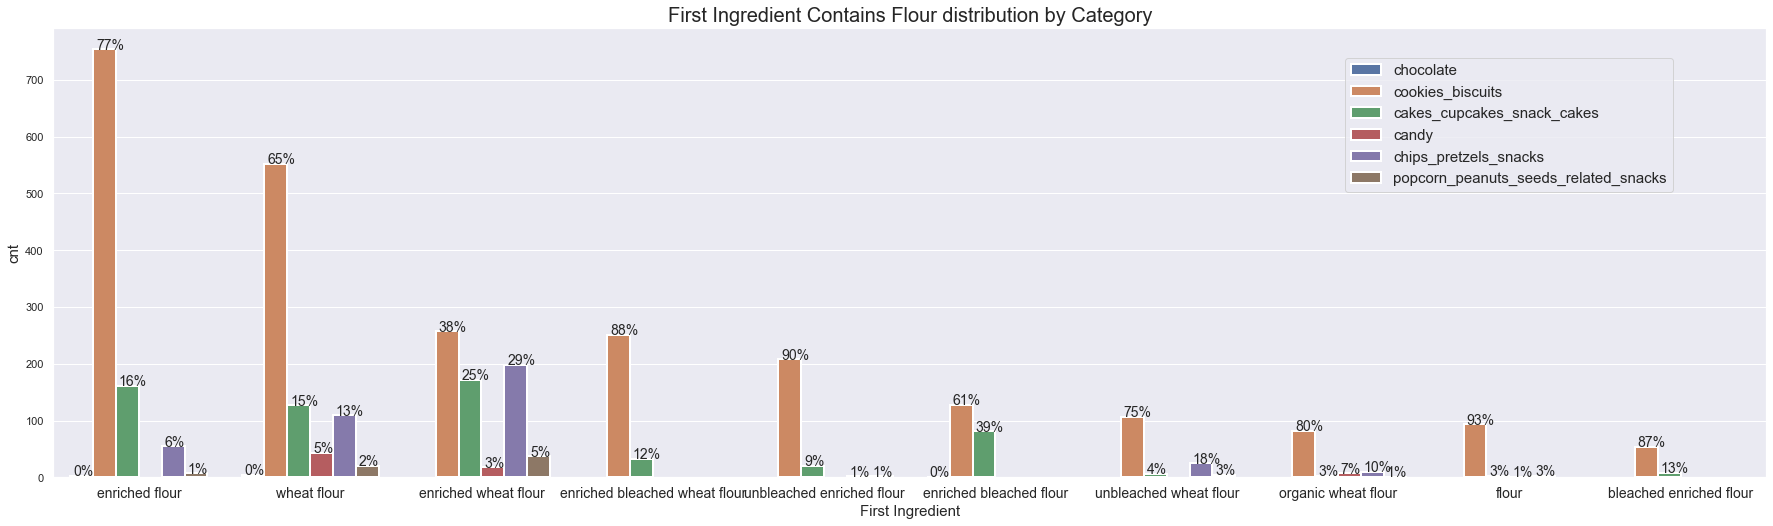

In [13]:
sns.set(rc={'figure.figsize':(30.7,8.27)})

ax = sns.countplot(x=food_train.first_ingredient, data=food_train,
                   # facecolor=(0, 0, 0, 0),
                   linewidth=2,
                   hue = food_train.category,
                   order=food_train.first_ingredient[food_train.first_ingredient.str.contains("flour")].value_counts().iloc[0:10].index
                   #,legend=False
                  )
plt.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=15)
#plt.tight_layout()
plt.title("First Ingredient Contains Flour distribution by Category",fontsize=20)
ax.set_xlabel('First Ingredient',fontsize=15)
ax.set_ylabel('cnt',fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

with_hue(ax, food_train.first_ingredient[food_train.first_ingredient.str.contains("flour")], 10, 6) 

It can make sense to combine them all,<br>
the distribution of each flour ingredient is kind of similiar.

### Exploring Brand

In [22]:
food_train = clean_brand(food_train)
print("# Unique Brands:", len(food_train.brand.unique()))

# Unique Brands: 4651


We see there is a difference in the category distribution between the different brands. (Appendix)

### grm Serving Size 

Let's Create grm_serving_size by multiply the ml by 1000.

In [28]:
food_train['grm_serving_size'] = food_train.apply((lambda a: 1000*a.serving_size if a.serving_size_unit == 'ml' else a.serving_size),axis=1)

In [29]:
food_train['grm_serving_size'].describe()

count     31751.000000
mean         59.365651
std        2767.738872
min           0.225000
25%          28.000000
50%          30.000000
75%          40.000000
max      480000.000000
Name: grm_serving_size, dtype: float64

Maybe it's worth to do log transformation to see the distribution better.

In [ ]:
food_train['scaled_serving_size'] = np.log(food_train.grm_serving_size)

#### Scaled Serving Size Per Category

Text(0.5, 1.0, 'Scaled serving size')

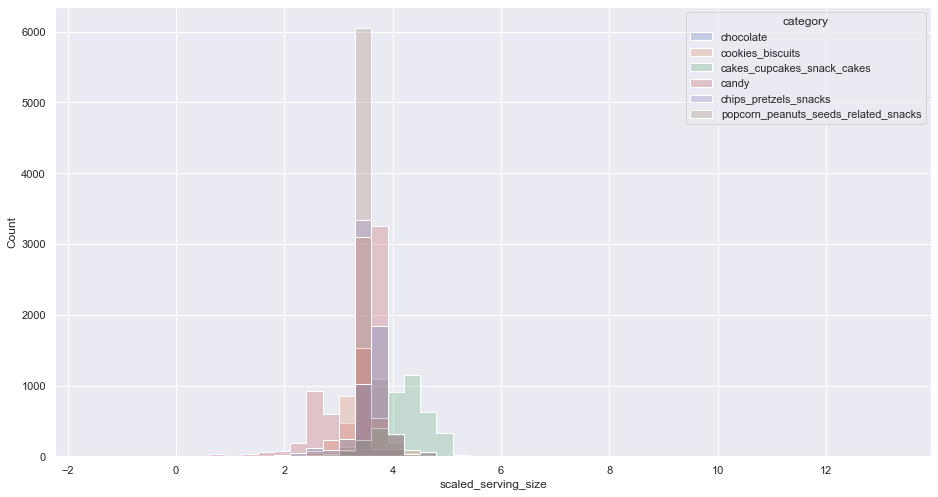

In [74]:
sns.histplot(data=food_train, x='scaled_serving_size',hue = 'category', stat='count', edgecolor=None, binwidth=0.3, element="step")
ax.set_title('Scaled serving size')

We definitely see that each category has a particular serving size distribution:<br> e.g. candy has mostly lower values, while 'cake' has mostly higher values.

## Nutrients Data Set

In [5]:
food_nutrients_full= pd.merge(pd.merge(food_nutrients, nutrients, on="nutrient_id"), food_train[['idx','category']], on="idx")

<AxesSubplot:title={'center':'Category per Nutrient Unit'}>

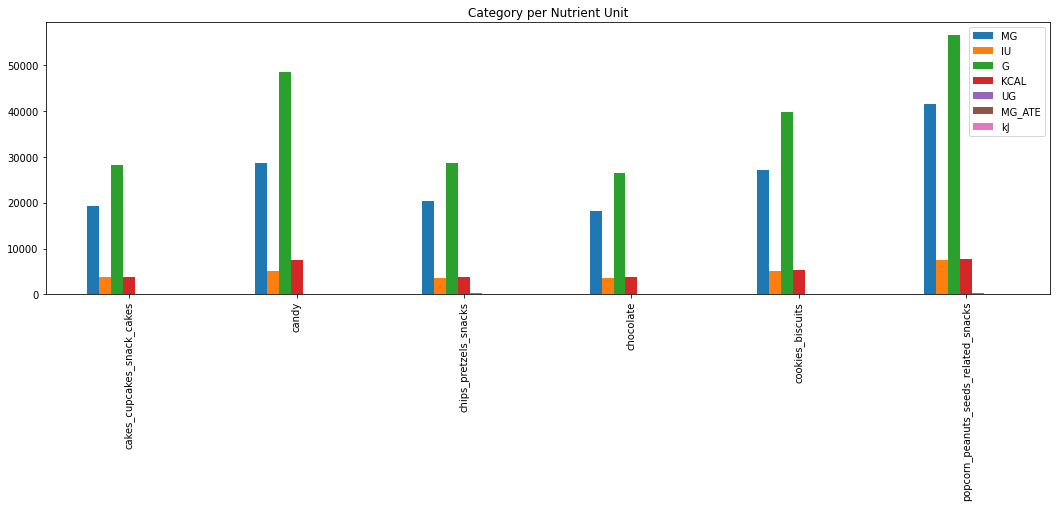

In [12]:
column_name = 'unit_name'
keywords = food_nutrients_full.unit_name.unique()
keywords_dict = {}
categories = ['cakes_cupcakes_snack_cakes','candy','chips_pretzels_snacks','chocolate','cookies_biscuits','popcorn_peanuts_seeds_related_snacks']
for word in keywords:
    keywords_dict[word] = {}
    word_dict = {}
    for category in categories:
        category_cnt = sum(food_nutrients_full[column_name][food_nutrients_full.category == category].map(lambda a: 1 if a == word else 0))
        keywords_dict[word][category] = category_cnt
df_nutrient_unit = pd.DataFrame(keywords_dict)
df_nutrient_unit_t = df_nutrient_unit.T
df_nutrient_unit.plot(kind = 'bar',title = 'Category per Nutrient Unit',figsize=(18,5))

looking at the nutrient unit name, it doesn't seem to have the best information about category inside.
Therefore we decide to use only the amount of each nutrient.

## Food Nutrients Data Set

In [219]:
print ( "# Unique Nutrients:" ,len(food_nutrients.nutrient_id.unique()))

# Unique Nutrients: 48


In [ ]:
food_nutrients_joined = pd.merge(pd.get_dummies(food_nutrients.pivot(index='idx', columns='nutrient_id', values='amount').iloc[: ,0:49]).add_prefix('nutrient_'), food_train, on="idx")
food_nutrients_joined.fillna(0)

Let's take a look at Protein nutrient (id 1003).

In [23]:
food_nutrients_joined['nutrient_1003'].describe()

count    31722.000000
mean         6.975735
std          6.325881
min          0.000000
25%          3.330000
50%          5.260000
75%          8.000000
max        100.000000
Name: nutrient_1003, dtype: float64

We don't need to scale the nutrients becuase we will use Tree model.

<AxesSubplot:xlabel='nutrient_1003', ylabel='Count'>

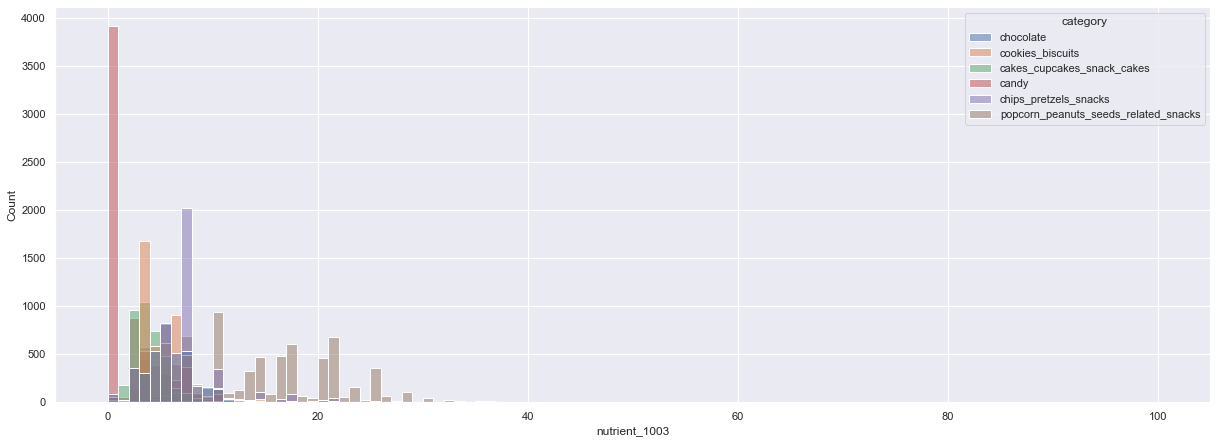

In [24]:
sns.set(rc={'figure.figsize':(20.7,7.27)})
sns.histplot(data=food_nutrients_joined, x='nutrient_1003', edgecolor=None,hue = 'category', binwidth=1)

We see that for some values there is almost absolute category seperation.

## Exploring the Images Data Set 

#### Average image per category - On the Appendix

#### Eigenimages to visualize the components that describe each class the best

Number of PC:  25


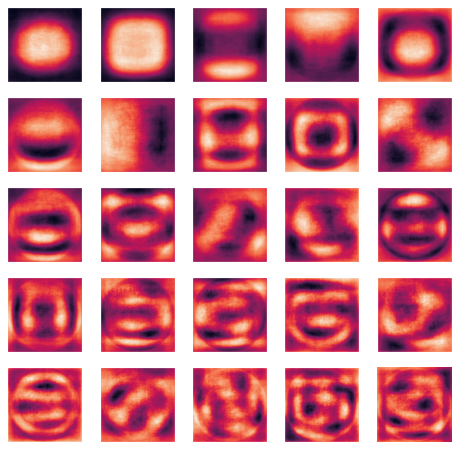

Number of PC:  24


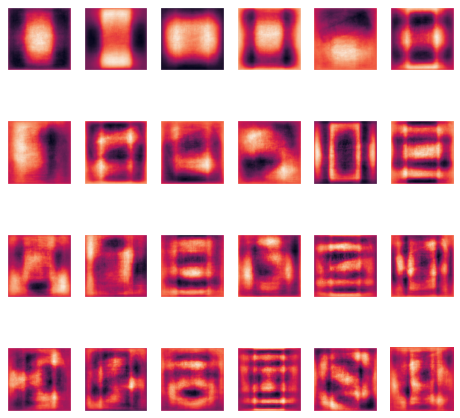

Number of PC:  45


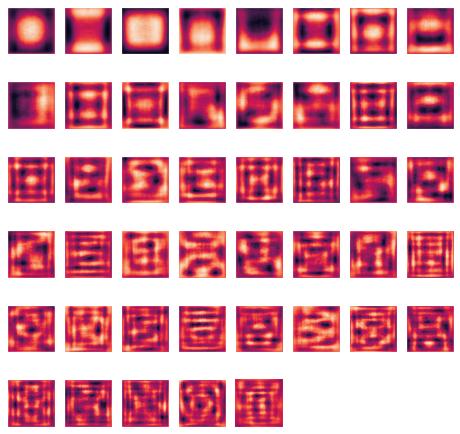

Number of PC:  32


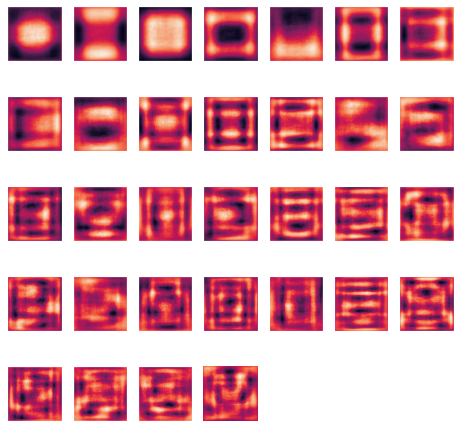

Number of PC:  36


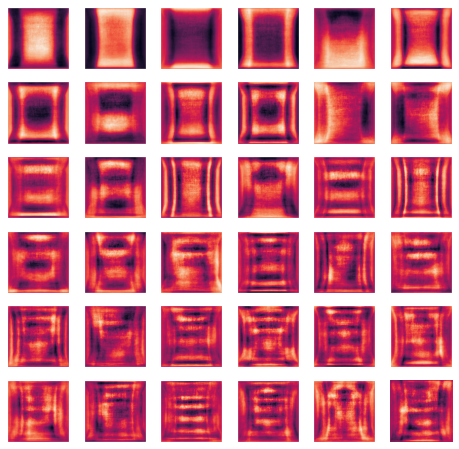

Number of PC:  31


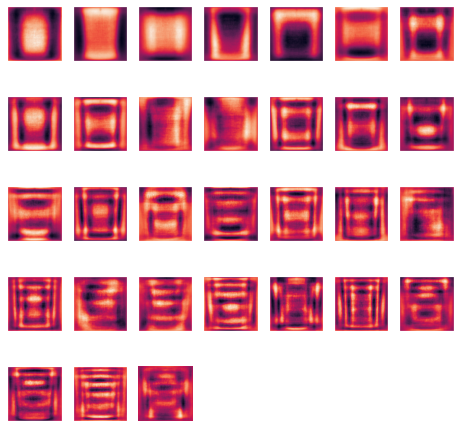

In [305]:
dict_of_plot_pca = {category: plot_pca(eigenimages( dict_of_category_images[category], category)) for category in categories }

We see different components between the categories, but we are not pretend to understand those components, that's why we will use CNN to handle it.